In [0]:
!pip install torch
!pip install torchaudio

     |████████████████████████████████| 3.2MB 8.8MB/s 
     |████████████████████████████████| 752.0MB 15kB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.5.0 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


In [0]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchaudio

In [0]:
# train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True) 
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

In [3]:
test_dataset[0][0][0]

tensor([ 0.0010,  0.0012,  0.0009,  ..., -0.0004, -0.0001,  0.0002])

In [4]:
audioData = test_dataset[1][0][0]
sr = test_dataset[1][1]
audioData, audioData.shape

(tensor([ 0.0017,  0.0012,  0.0005,  ..., -0.0002,  0.0000, -0.0005]),
 torch.Size([142640]))

In [5]:
len(audioData) / sr 

8.915

In [6]:
import IPython.display as ipd
ipd.Audio(audioData, rate=sr)

sampling rate를 높고 낮춰서 샘플링.

In [7]:
y_8k = librosa.resample(audioData.numpy(), sr, 8000) # (1초당) 샘플링 rate가 많을 수록 정확한 소리가 남
ipd.Audio(y_8k, rate=8000)

In [8]:
y_2k = librosa.resample(audioData.numpy(), sr, 4000)
ipd.Audio(y_2k, rate=4000)

## Normalization

In [9]:
audio_np = audioData.numpy()
normed_wav = audio_np / max(np.abs(audio_np))
ipd.Audio(normed_wav, rate=sr)

In [10]:
Bit = 8
max_value = 2 ** (Bit-1)

quantized_8_wav = normed_wav * max_value
quantized_8_wav = np.round(quantized_8_wav).astype(int)
quantized_8_wav = np.clip(quantized_8_wav, -max_value, max_value-1)
ipd.Audio(quantized_8_wav, rate=sr)

## MU-law encoding

In [0]:
def mu_law(x, mu=255):
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

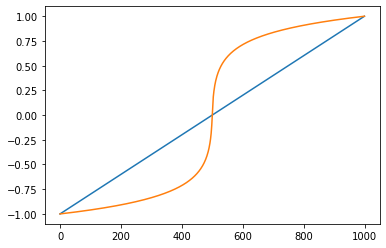

In [12]:
x = np.linspace(-1, 1, 1000)
x_mu = mu_law(x)

plt.figure(figsize=[6, 4])
plt.plot(x)
plt.plot(x_mu)
plt.show()

normalization은 자주 하지만 mu-law는 상황마다 다름

In [13]:
wav_mulaw = mu_law(normed_wav)
ipd.Audio(wav_mulaw, rate=sr)

# waveform
오디오의 자연적인 표현

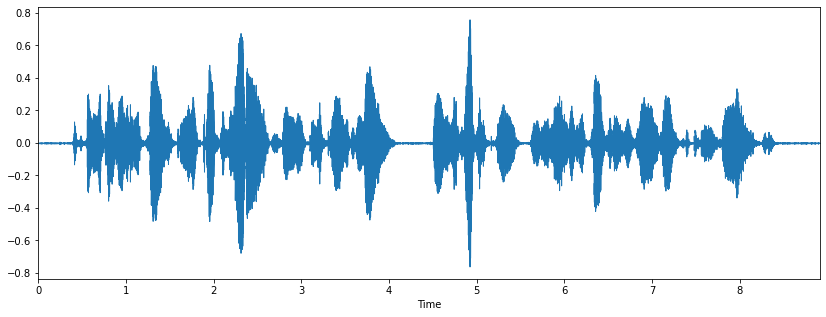

In [14]:
import librosa.display

fig = plt.figure(figsize = (14,5))
librosa.display.waveplot(audio_np, sr=sr)

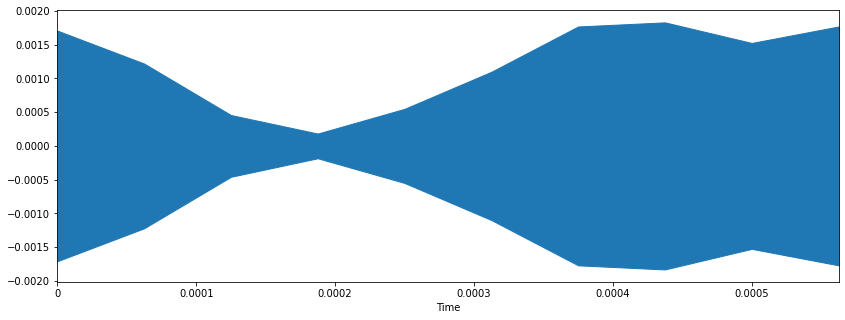

In [15]:
fig = plt.figure(figsize = (14,5))
librosa.display.waveplot(audio_np[0:10], sr=sr)

In [0]:
A = 0.9
f = 440
phi = np.pi/2
fs = 22050
t = 1

In [0]:
def Sinusoid(A,f,phi,fs,t):
    t = np.arange(0,t,1.0/fs)
    x = A * np.cos(2*np.pi*f*t+phi)
    return x

In [18]:
sin = Sinusoid(A,f,phi,fs,t)
sin

array([ 5.51091060e-17, -1.12545471e-01, -2.23324063e-01, ...,
        3.30596635e-01,  2.23324063e-01,  1.12545471e-01])

In [19]:
ipd.Audio(sin, rate=fs)

In [20]:
sin2 = Sinusoid(1.2,294,phi,fs,t)
ipd.Audio(sin2, rate=fs)

In [21]:
complexwave = sin +sin2
ipd.Audio(complexwave, rate=fs)

In [22]:
def generate_sinusoid_scale(pitches=[69], duration=0.5, Fs=22050, amplitude_max = 0.5):
    N = int(duration * Fs)
    t = np.arange(N) / Fs
    x = []
    for p in pitches:
        omega = 2 ** (( p - 69 ) / 12 ) * 440
        x = np.append(x, np.sin(2 * np.pi * omega * t))
    x = amplitude_max * x/np.max(x)
    return x

duration = 1
Fs = 22050

pitches = [36,48,60,72,84,96]
x = generate_sinusoid_scale(pitches=pitches, duration=duration, Fs=Fs)
print('Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}', flush=True)
ipd.display(ipd.Audio(data=x, rate=Fs))

Pitch class C = {..., C1, C2, C3, C4, C5, C6, ...}


## Spectrogram

프로세스는 입력신호에 대해서 window function을 통과하여 window size만큼 sampling 된 data를 받아서 Discrete Fourier Transform을 거치게 됩니다. DFT를 거친 신호들은 Frequency와 Amplitude의 영역을 가지는 Spectrum이 됩니다. 이후 이를 90도로 회전시켜서, time domain으로 stack하게 됩니다.

Spectrogram은 Frequency Scale에 대해서 Scaling이 이루어집니다. 주파수 영역에 Scaling을 하는 이유는, 인간의 주파수를 인식하는 방식과 연관이 있습니다.

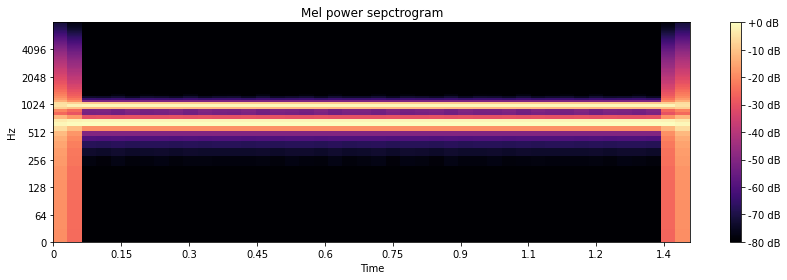

In [23]:
import librosa.display

S = librosa.feature.melspectrogram(complexwave,sr=fs,n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr,x_axis='time',y_axis='log')
plt.title("Mel power sepctrogram")
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

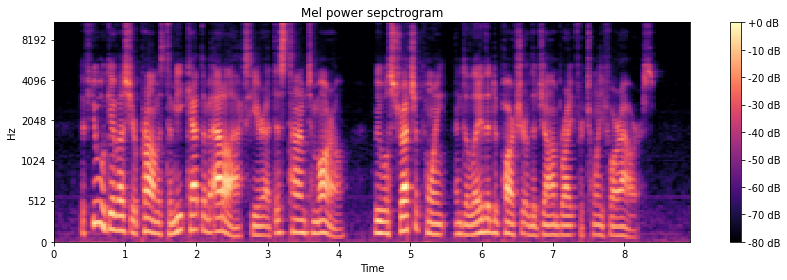

In [24]:
import librosa.display

S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels = 128)
log_S = librosa.power_to_db(S, ref=np.max)
# power_to_db : 일률을 데시벨로 나타내줌
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power sepctrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

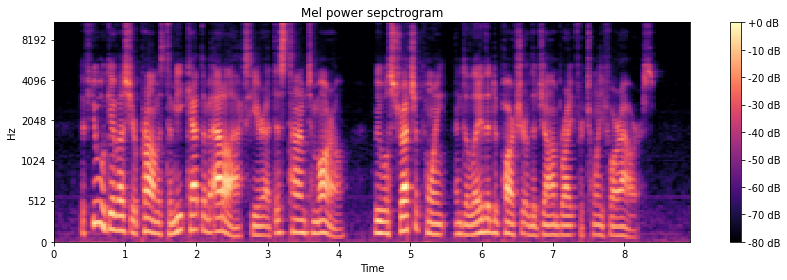

In [25]:
#female data

S = librosa.feature.melspectrogram(audio_np, sr=sr, n_mels = 128)
log_S = librosa.power_to_db(S, ref=np.max)
# power_to_db : 일률을 데시벨로 나타내줌
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
plt.title('Mel power sepctrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

## DFT  
모든 영역대의 주파수를 sequential 하게 append하는 것

In [0]:
def DFT(x):
    N = len(x)
    X = np.array([])
    nv = np.arange(N)
    
    for k in range(N):
        s = np.exp(1j*2*np.pi*k/N*nv)
        X = np.append(X, sum(x*np.conjugate(s)))
    return X

In [0]:
# dftcom = DFT(complexwave)
# 시간 오래 걸림

## STFT(Short-Time Fourier Transform)
DFT는 한 번에 하는 것처럼 보임. STFT는 시간의 길이를 나눠서 푸리에 변환을 함.

In [29]:
len(audio_np)

142640

In [30]:
# STFT
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
S.shape, len(S[0]), S[0][0]

((513, 279), 279, (-0.40651232-0j))

In [31]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=256, win_length=1024)
S.shape, len(S[0]), S[0][0]
# timelength가 길면 문제

((513, 558), 558, (-0.40651232-0j))

In [32]:
S[0][0]
# 실수부와 허수부가 나옴

(-0.40651232-0j)

In [33]:
D = np.abs(S)**2
D.shape

(513, 558)

In [34]:
D[0][0]
# 허수부가 날아감

0.16525227

In [35]:
D1 = librosa.amplitude_to_db(np.abs(librosa.stft(audio_np)), ref=np.max)
D1[0:1], D1.shape

(array([[-49.582214, -53.221443, -69.40927 , -63.286377, -60.385105,
         -80.      , -72.64017 , -80.      , -74.605804, -66.75234 ,
         -63.624477, -56.94889 , -48.425205, -65.9156  , -51.998558,
         -50.52082 , -45.93135 , -55.456635, -46.19043 , -50.812138,
         -49.811108, -45.132236, -59.845913, -39.171844, -38.594326,
         -80.      , -36.91059 , -46.898132, -45.051826, -45.27781 ,
         -54.06365 , -48.5391  , -48.108253, -62.225014, -47.172253,
         -58.316864, -54.84099 , -53.217   , -47.087154, -48.733166,
         -46.836906, -42.88112 , -41.671043, -54.635567, -45.83451 ,
         -39.845047, -40.83565 , -51.205612, -46.355255, -71.46452 ,
         -64.60708 , -43.659634, -43.030956, -47.737053, -51.744625,
         -45.44442 , -42.135433, -50.707874, -52.65842 , -56.41753 ,
         -52.745575, -52.199684, -61.29219 , -53.328876, -58.13037 ,
         -50.681038, -52.5872  , -43.79923 , -47.83495 , -42.65924 ,
         -42.53325 , -54.500774, -

Text(0.5, 1.0, 'Linear-frequency power sepctrogram')

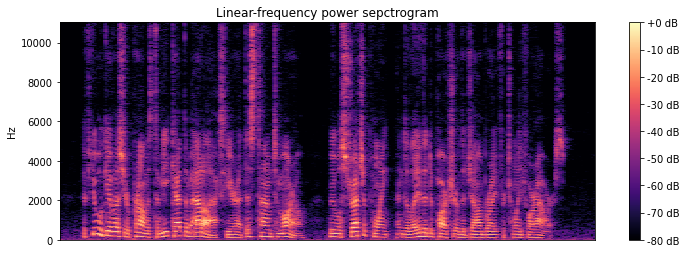

In [36]:
plt.figure(figsize=(12,4))
librosa.display.specshow(D1, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power sepctrogram')

Text(0.5, 1.0, 'Linear-frequency power sepctrogram')

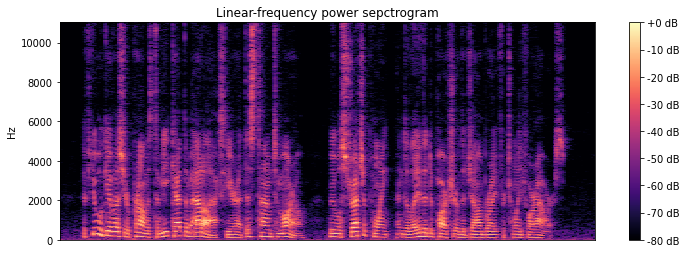

In [37]:
# female
plt.figure(figsize=(12,4))
librosa.display.specshow(D1, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power sepctrogram')

윈도우 사이즈는 일반적으로 time과 frequency의 resolutions을 제어
- short-window : 낮은 frequency resolution, 높은 time-resolution을 가짐
- Long-window : 높은 frequency resolution을 가지며, 낮은 time-resolution을 가짐

In [38]:
def frame_audio(audio, FFT_size=1024, hop_size=20, sample_rate = 22050):
    audio = np.pad(audio, int(FFT_size/2), mode='reflect')
    frame_len = np.round(sample_rate*hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num, FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    return frames

audio_framed = frame_audio(audio_np)
print("Framed audio shape: {}".format(audio_framed.shape))

Framed audio shape: (324, 1024)


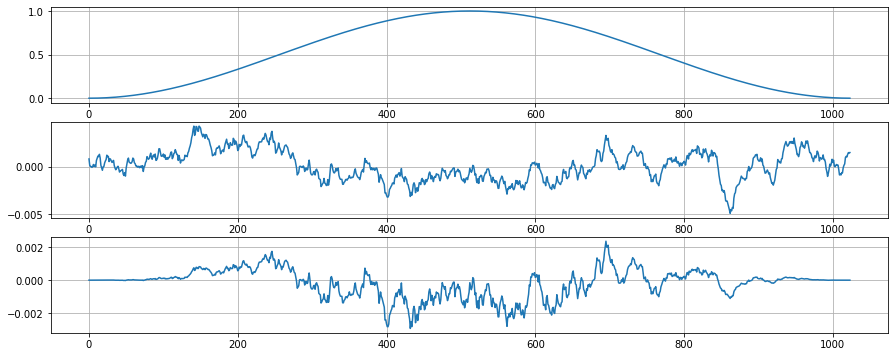

In [39]:
from scipy import signal

window = signal.get_window("hann", 1024, fftbins=True)
audio_win = audio_framed * window
ind = 2
plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.plot(window)
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(audio_framed[ind])
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(audio_win[ind])
plt.grid(True)
plt.show()

- spectrogram을 만들때 기존 waveform 그대로 냅두었으면 (amplitude), 기존 waveform의 y축을 power (amplitude^2)으로 바꿔서 spectrogram을 한 것이 power_to_db
-  power_to_db는 학습할 때는 사용하지 않음



## mel scale

In [0]:
S = librosa.core.stft(audio_np, n_fft=1024, hop_length=512, win_length=1024)
# phase 에 대한 정보를 날린다.
D = np.abs(S)**2

In [41]:
mel_basis = librosa.filters.mel(sr, 1024, n_mels=40)
mel_S = np.dot(mel_basis, D)
mel_S.shape

(40, 279)

## log compression

In [42]:
log_mel_S = librosa.power_to_db(mel_S)
log_mel_S.shape

(40, 279)

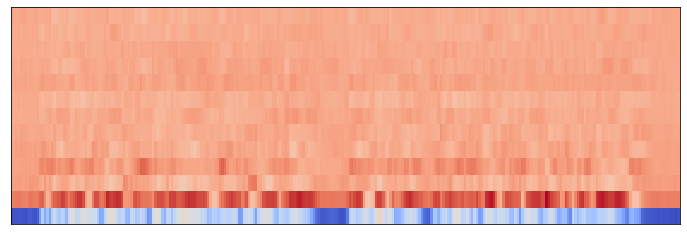

In [43]:
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc)

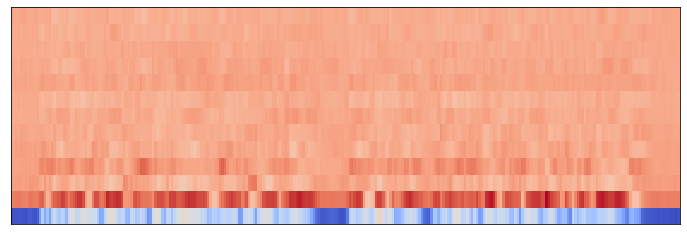

In [44]:
# female
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
plt.figure(figsize=(12,4))
librosa.display.specshow(mfcc)

## DCT (Discrete cosine transform)
DCT는 데이터의 양을 줄이는 방식

Filter Bank는 모두 Overlapping 되어 있기 때문에 Filter Bank 에너지들 사이에 상관관계가 존재하기 때문이다. DCT는 에너지들 사이에 이러한 상관관계를 분리 해주는 역활을 해줍니다.

DCT는 선형 변환

하지만 여기서 26개 DCT Coefficient 들 중 12만 남겨야 하는데, 그 이유는 DCT Coefficient 가 많으면, Filter Bank 에너지의 빠른 변화를 나타내게 되고, 이것은 음성인식의 성능을 낮추게 됩니다.

(13, 279)


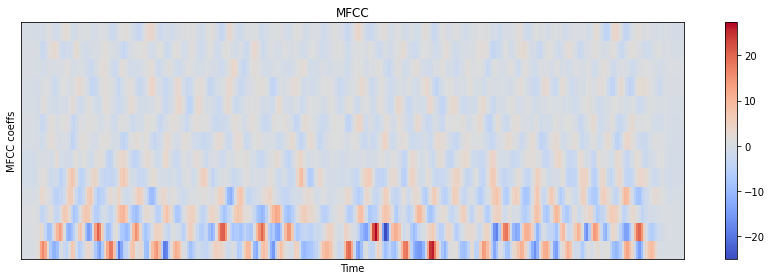

In [45]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

(13, 279)


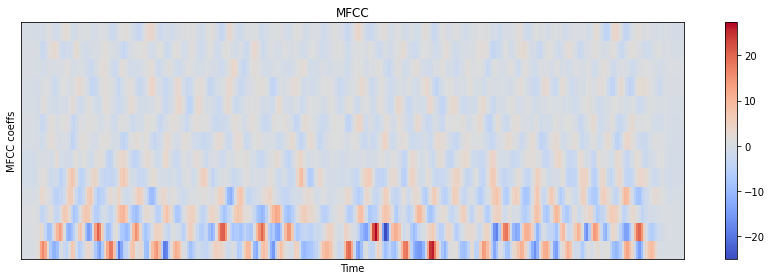

In [46]:
# female data
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [47]:
audioData = test_dataset[200][0][0]
sr = test_dataset[200][1]
ipd.Audio(audioData, rate=sr)

In [0]:
audio_np = audioData.numpy()

In [0]:
def change_pitch_and_speed(data):
    y_pitch_speed = data.copy()
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high=1)
    speed_fac = 1.0 / length_change
    tmp = np.interp(np.arange(0, len(y_pitch_speed), speed_fac), np.arange(0, len(y_pitch_speed)), y_pitch_speed)
    minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
    y_pitch_speed *= 0
    y_pitch_speed[0:minlen] = tmp[0:minlen]
    return y_pitch_speed


def change_pitch(data, sr):
    y_pitch = data.copy()
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    y_pitch = librosa.effects.pitch_shift(y_pitch.astype('float64'), sr, n_steps=pitch_change,
                                          bins_per_octave=bins_per_octave)
    return y_pitch

# 특정 값을 더하는 함수
def value_aug(data):
    y_aug = data.copy()
    dyn_change = np.random.uniform(low=1.5, high=3)
    y_aug = y_aug * dyn_change
    return y_aug

# noise를 scale에 맞춰 추가
def add_noise(data):
    noise = np.random.randn(len(data))
    data_noise = data + 0.005 * noise
    return data_noise

# 멜로디와 리듬 분리, harmonic만 쓰지만 노래 등에서 percussive도 넣음
def hpss(data):
    y_harmonic, y_percussive = librosa.effects.hpss(data.astype('float64'))
    return y_harmonic, y_percussive

# array를 밈 (말의 도치가 일어남), 잘 되지는 않음
def shift(data):
    return np.roll(data, 1600)

# 빨리감기
def stretch(data, rate=1):
    input_length = len(data)
    streching = librosa.effects.time_stretch(data, rate)
    if len(streching) > input_length:
        streching = streching[:input_length]
    else:
        streching = np.pad(streching, (0, max(0, input_length - len(streching))), "constant")
    return streching

# 위에꺼랑 비슷
def change_speed(data):
    y_speed = data.copy()
    speed_change = np.random.uniform(low=0.9, high=1.1)
    tmp = librosa.effects.time_stretch(y_speed.astype('float64'), speed_change)
    minlen = min(y_speed.shape[0], tmp.shape[0])
    y_speed *= 0
    y_speed[0:minlen] = tmp[0:minlen]
    return y_speed

In [0]:
def waveform_aug(waveform,sr):
  y = change_pitch(waveform,sr)
  fig = plt.figure(figsize = (12,4))
  librosa.display.waveplot(y, sr)
  ipd.display(ipd.Audio(data=y,rate=sr))
  return y, sr

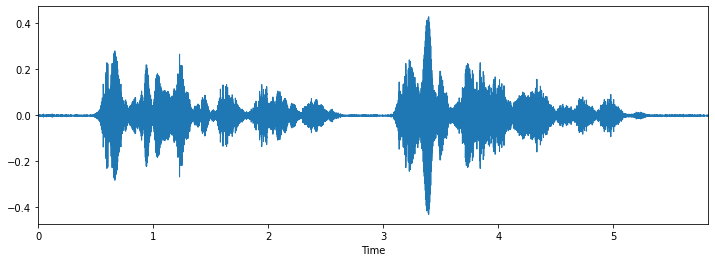

In [51]:
ipd.display(ipd.Audio(data=audio_np,rate=sr))
y, sr = waveform_aug(audio_np,16000)

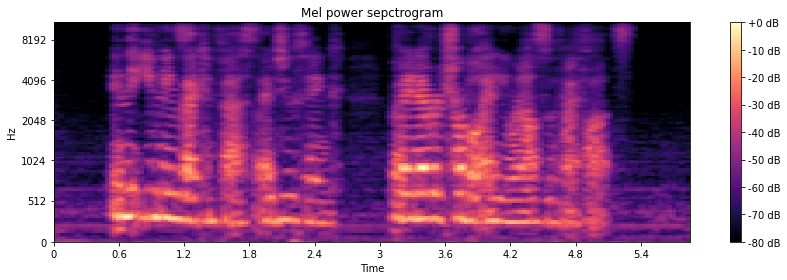

In [52]:
S = librosa.feature.melspectrogram(y,sr=fs,n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr,x_axis='time',y_axis='mel')
plt.title("Mel power sepctrogram")
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [0]:
data_nosie = add_noise(audio_np)
data_roll = shift(audio_np)
data_stretch = stretch(audio_np)
pitch_speed = change_pitch_and_speed(audio_np)
pitch = change_pitch(audio_np, 16000)
speed = change_speed(audio_np)
value = value_aug(audio_np)
y_harmonic, y_percussive = hpss(audio_np)
y_shift = shift(audio_np)

In [0]:
train_audio_transforms = torch.nn.Sequential(
      torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
      torchaudio.transforms.FrequencyMasking(freq_mask_param=15, iid_masks=False),
      torchaudio.transforms.TimeMasking(time_mask_param=35, iid_masks=False)
)

In [55]:
masking_freq = train_audio_transforms(test_dataset[0][0])
masking_freq.shape

torch.Size([1, 128, 574])

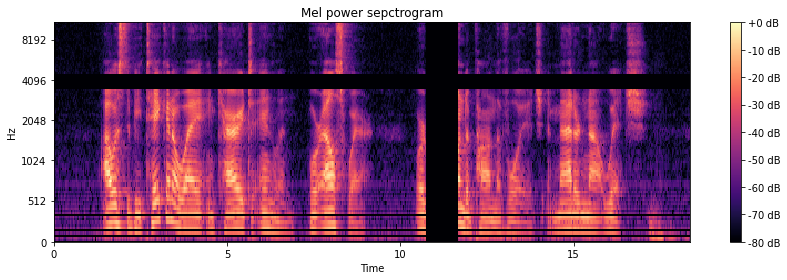

In [56]:
S = librosa.feature.melspectrogram(y,sr=fs,n_mels=128)
log_S = librosa.power_to_db(masking_freq[0,:,:].numpy(), ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sr,x_axis='time',y_axis='mel')
plt.title("Mel power sepctrogram")
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

In [0]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_pass(cutoff, fs, btype, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

def butter_filter(data, cutoff, fs, btype, order=5):
    b, a = butter_pass(cutoff, fs, btype, order=order)
    y = lfilter(b, a, data)
    return y

In [0]:
# Filter requirements.
order = 6
fs = 16000     # sample rate, Hz
cutoff = 2048  # desired cutoff frequency of the filter, Hz

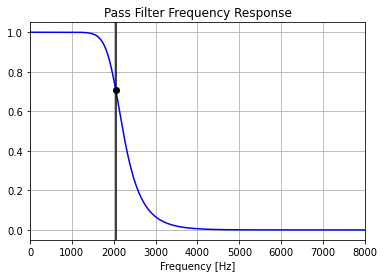

In [59]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_pass(cutoff, fs, 'lowpass',order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Pass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

In [60]:
T = len(audio_np)/sr   # seconds
n = int(T * sr) # total number of samples
t = np.linspace(0, T, n, endpoint=False)

# Filter the data, and plot both the original and filtered signals.
y = butter_filter(audio_np, cutoff, fs, 'lowpass', order)
ipd.Audio(y, rate=fs)

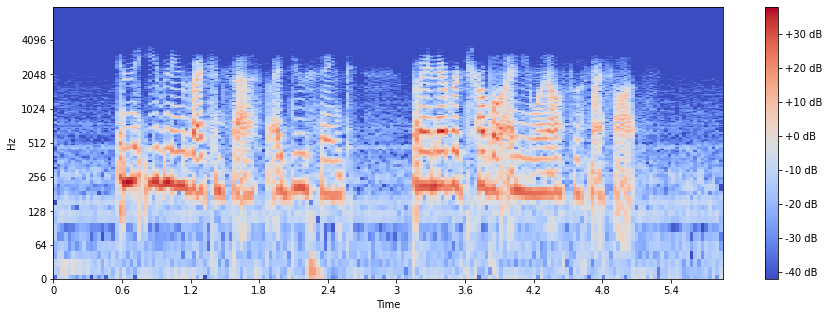

In [61]:
X = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024) # get frequency to STFT
S = librosa.amplitude_to_db(abs(X)) # Change Amplitude to decibel
plt.figure(figsize=(15, 5)) # get figure size
librosa.display.specshow(S, sr=fs, hop_length=512, x_axis='time', y_axis='log') #display
plt.colorbar(format='%+2.0f dB')

In [0]:
def visualization(audio, sr):
  S = librosa.core.stft(audio, n_fft=1024, hop_length=512, win_length=1024)
  power_S = abs(S) ** 2 # (n_fft, time)
  db_S = librosa.power_to_db(power_S)  
  
  mel_filters = librosa.filters.mel(sr, n_fft=1024, n_mels=40) # (n_mels, n_fft)
  power_mel_S = np.dot(mel_filters, power_S) # (n_mels, time)
  db_mel_S = librosa.power_to_db(power_mel_S, ref=np.max)

  mfcc = librosa.feature.mfcc(audio, sr, n_mfcc=13)

  plt.figure(figsize=(10, 5)) # get figure size
  librosa.display.specshow(db_S, sr=sr, hop_length=512, x_axis='time', y_axis='mel') #display
  plt.colorbar(format='%+2.0f dB')
  
  plt.figure(figsize=(10, 5)) # get figure size
  librosa.display.specshow(db_mel_S, sr=sr, hop_length=512, x_axis='time', y_axis='mel') #display
  plt.colorbar(format='%+2.0f dB')

  plt.figure(figsize=(10, 5)) # get figure size
  librosa.display.specshow(mfcc) #display
  plt.colorbar(format='%+2.0')

def aug_and_visualization(original, sr, aug_fn):
  # wave단계에서 pitch shift방식을 시도
  augmented = aug_fn(original, sr)
  visualization(original, sr)
  visualization(augmented, sr)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fd140ce71e0> (for post_execute):


ValueError: ignored

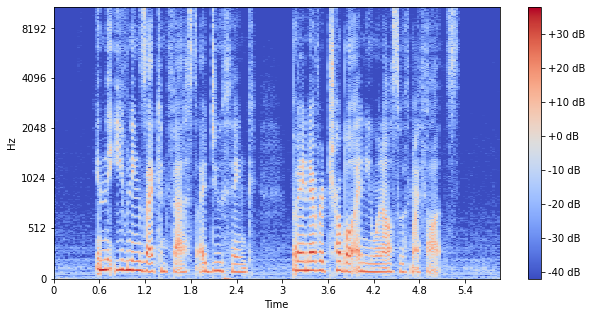

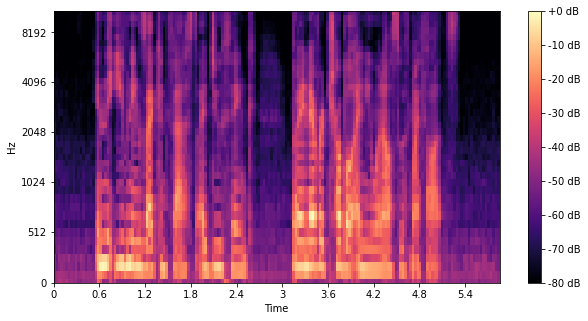

ValueError: ignored

<Figure size 720x360 with 2 Axes>

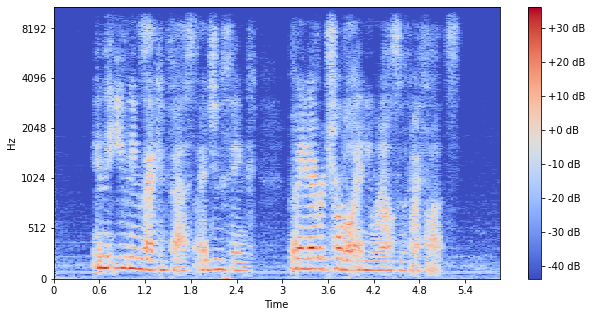

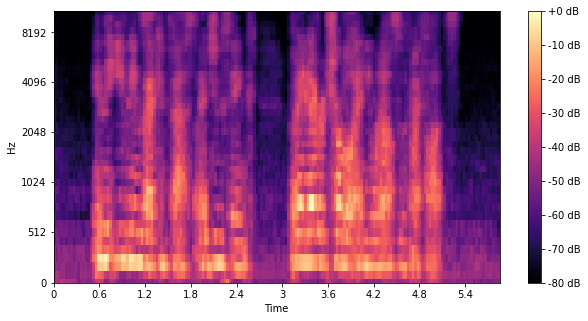

ValueError: ignored

<Figure size 720x360 with 2 Axes>

In [63]:
aug_and_visualization(audioData.numpy(), sr, change_pitch)

In [0]:
train_audio_transforms = torch.nn.Sequential(
      torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
      torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
      torchaudio.transforms.TimeMasking(time_mask_param=35)
)
valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

In [0]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

def load_dataset(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, _, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        
    return spectrograms

def get_dataloader(data):
    x_train = load_dataset(data, "train")
    x_valid = load_dataset(data, 'valid')
    print(type(x_train))
    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std

    train_set = Dataset(x_train)
    vaild_set = Dataset(x_valid)

    train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=4, shuffle=False, drop_last=False)
    return train_loader, valid_loader

In [68]:
train_loader, valid_loader = get_dataloader(test_dataset)

<class 'list'>


ValueError: ignored